# Simulator for testing control algorithm 
- with pinocchio for robot model and dynamics

## House Keeping

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import pinocchio as pin
import example_robot_data as robex
from controller import PID_controller
# import robot_pinocchio 

working_path = os.getcwd()
print(working_path)

/home/anran.zhang/github/robot_control_playground


In [2]:
def plot_states(q, q_dot,torque,t):
    n_col = 3
    N_sim = q.shape[1]
    nq = q.shape[0]

    fig, axes = plt.subplots(nrows=nq, ncols=n_col, figsize=(8, 8))
    fig.tight_layout()

    for i in range(nq):
        plt.subplot(nq, n_col, i * n_col + 1)
        line, = plt.plot(t,q[i, :])
        plt.xlabel('$t$')
        plt.ylabel(f"q[{i}]")
        plt.grid()

    for i in range(nq):
        plt.subplot(nq, n_col, i * n_col + 2)
        line, = plt.plot(t,q_dot[i, :])
        plt.xlabel('$t$')
        plt.ylabel(f"q_dot[{i}]")
        plt.grid()

    t1 = np.concatenate((np.zeros((torque.shape[0],1)), torque),axis=1) # added one col to u
    for i in range(nq):
        plt.subplot(nq, n_col, i * n_col + 3)
        line, = plt.plot(t,t1[i, :])
        plt.xlabel('$t$')
        plt.ylabel(f"torque[{i}]")
        plt.grid()

    plt.tight_layout()
    plt.show()

## Robot

In [3]:
ur5 = robex.load('ur5') # pinocchio model robotWrapper
p_model = ur5.model
p_data = ur5.data

In [4]:
# test 
q_test = np.array([0,0,0,0,0,0])
print(pin.computeGeneralizedGravity(p_model,p_data,q_test))

[ 0.00000000e+00 -5.91707982e+01 -1.56838285e+01 -1.70861596e-12
  0.00000000e+00  0.00000000e+00]


In [5]:
# robotState, wrapper class for joint configuration and joint velocity of robot
class robotState:
    def __init__(self,robot):
        # DOF = rg_model.DOF
        self.DOF = robot.nq
        self.q = np.zeros(self.DOF)
        self.dq = np.zeros(self.DOF )
    
    def update_state(self,q,dq):
        self.q = q
        self.dq = dq
        
    def reset(self):
        self.q = np.zeros(self.DOF)
        self.dq = np.zeros(self.DOF)

    def print_current_state(self):
        print(f'q: {self.q}, dq: {self.dq}')

## Simulation

In [6]:
q0 = np.array([0,0,0,0,0,0])
q_goal = np.array([1.0]*6)
dt = 1e-3
t_interupt = 0.5
t_end = 5
robot_state = robotState(ur5)
pid_controller = PID_controller(ur5, robot_state, q0)
pid_controller.update_dynamics_parameters()

In [7]:
def erk1(robot, state, torque, dt):
    acceleration = pin.aba(robot.model, robot.data, state.q, state.dq, torque)
    state.dq += dt*acceleration
    state.q += dt*state.dq 
    return state

def erk3(robot,state, torque, dt):
    # Coefficients for the ERK3 method
    a1 = 0.25
    a2 = 3/4
    b1 = 2/3
    b2 = 1/3
    
    # acc
    acceleration = pin.aba(robot.model, robot.data, state.q, state.dq, torque)
    # Compute intermediate values
    k1 = state.dq
    k2 = state.dq + a1 * dt * acceleration
    k3 = state.dq + a2 * dt * acceleration

    # Calculate the next state and velocity
    state.dq += dt * acceleration
    state.q += dt * (b1 * k1 + b2 * k3)
    
    
def pinocchio_integrate(model,state,acc, dt):
    state.dq +=acc*dt
    state.q +=pin.integrate(model,state.q,state.dq*dt)

In [8]:
# simulation using pinocchio
pid_controller.clear_error_i()
robot_state.reset()

state_sim = np.zeros((12, 5000 + 1))
torque_sim = np.zeros((6, 5000))
ii = 0
for t in np.arange(0,t_end,dt):
    if (t < t_interupt):
        q_d = q0
    elif (t_interupt <= t <= t_end):
        q_d = q_goal
    torque = pid_controller.compute_torque(robot_state.q, q_d,dt)

    # integration
    erk3(ur5, robot_state,torque, dt)

    state_sim[:,ii] = np.concatenate((robot_state.q,robot_state.dq),axis=0)
    torque_sim[:,ii] = torque
    ii += 1

integration error erased!


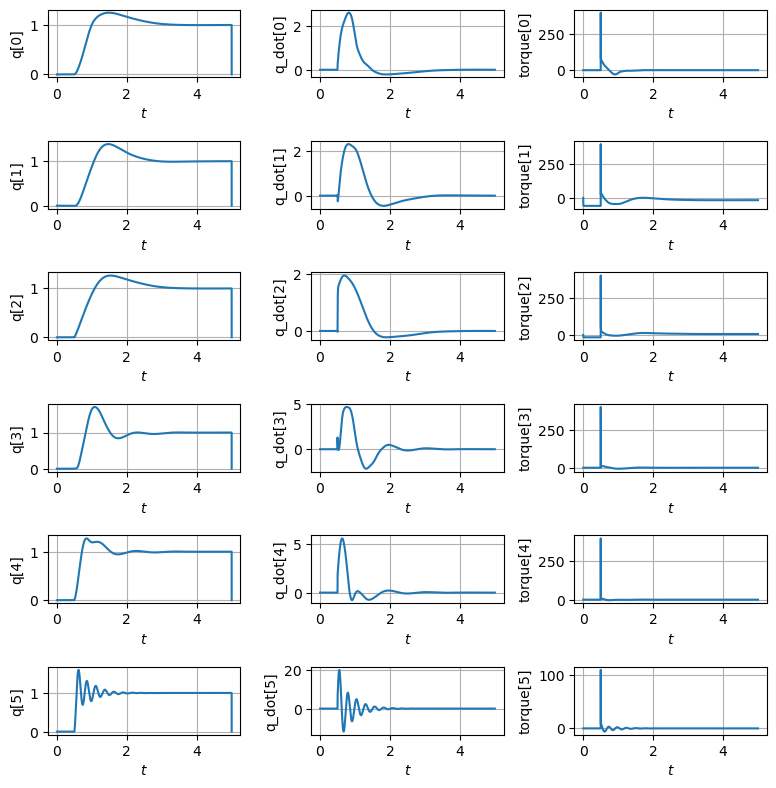

In [11]:
t = [ 1e-3*elem for elem in range(0,5001)]

# print(t.shape)
# print(t)
plot_states(state_sim[:6,], state_sim[6:,], torque_sim, t)